### 加载数据集

In [1]:
import pandas as pd

df_all = pd.read_csv('data.three_class.csv')
df_test = df_all[2716:3397]
df_train = pd.concat([df_all[0:2716], df_all[3397:3397]])

In [2]:
# Import packages. Run this cell.
import numpy as np
import numpy.random as rn
from numpy.core.fromnumeric import shape
from pyvis import network as net
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
import matplotlib.pyplot as plt 

### 训练词向量

In [3]:
# word2vec要求的输入格式: list(word)
wv_input = df_all['context'].map(lambda s: s.split(" "))   # [for w in s.split(" ") if w not in stopwords]
wv_input.head()                         

0    [, , , 冬奥, 事, 冰壶, 比赛, , 充满, 尖叫, , 摩擦, O, , , ,...
1    [包头, 疫情, 北京, 冬奥, 令人, 一生, 难忘, , , , , 刷到, 家门口, ...
2             [肖战, 期待, 冬奥, 赛场, , , , 抹, 中国, 红, 加油, 加油]
3                               [北京, 冬奥会, 闭幕式, 冬奥, 再见]
4                           [北京, 冬奥会, 闭幕式, 期待, 下次, 冬奥]
Name: context, dtype: object

In [4]:
from gensim import models

# Word2Vec
word2vec = models.Word2Vec(wv_input, 
                           vector_size=32,   
                           min_count=1,      
                           epochs=1000)      

### 神经网络

In [400]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import numpy as np

#device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [401]:
# 超参数
learning_rate = 5e-4
input_size = 300
num_epoches = 5
batch_size = 1

embed_size = 32
hidden_size = 32
num_layers = 1

In [425]:
# 数据集
class MyDataset(Dataset):
    def __init__(self, df):
        self.data = []
        self.label = []
        self.count = np.ones([len(word2vec.wv.key_to_index),3])
        self.word_in_w2v = []
        for t in df["emotion"].tolist():
            if t == 1:
                vec = [1, 0, 0]
            elif t == 0:
                vec = [0, 1, 0]
            else:
                vec = [0, 0, 1]
            '''
            if t == -1:
                vec = 0
            else:
                vec = 1
            '''
            self.label.append(vec)
        i = 0
        for s in df["context"].tolist():
            vectors = []
            sentence = []
            for w in s.split(" "):
                if w in word2vec.wv.key_to_index:
                    x = word2vec.wv[w]
                    vectors.append(x)  
                    sentence.append(w)
                    self.count[word2vec.wv.key_to_index[w],self.label[i]] += 1
            vectors = torch.Tensor(vectors)
            self.data.append(vectors)
            self.word_in_w2v.append(sentence)
            i += 1
        #print(word2vec.wv.key_to_index.keys())
        #print(np.sum(self.count,axis = 1)[0:300])
    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]
        word = self.word_in_w2v[index]
        return data, label ,word
    def getprob(self, words):
        D = np.zeros([3])
        if words not in word2vec.wv.key_to_index.keys():
            return 0,0
        D += self.count[word2vec.wv.key_to_index[words]]
        q = np.sum(D)
        D = D / [0.5,0.3,0.2]
        p = D / np.sum(D)
        return p,q
    def __len__(self):
        return len(self.label)
        


def collate_fn(data):
    """
    :param data: 第0维：data，第1维：label
    :return: 序列化的data、记录实际长度的序列、以及label列表
    """
    data.sort(key=lambda x: len(x[0]), reverse=True) 
    data_length = [len(sq[0]) for sq in data]
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    words = [i[2] for i in data]
    data = pad_sequence(x, batch_first=True, padding_value=0)   
    return data, torch.tensor(y, dtype=torch.float32), data_length, words

def reward_fun(out_0,action,out_1,dic_dis, freq, alpha = 10):
    if freq < 50:
        reward = 0
        return reward
    else:
        dic_reward = -alpha * (np.sum(action * np.log(dic_dis)))
        out_0 = out_0.squeeze()
        out_1 = out_1.squeeze()
        policy_reward = (out_1[np.argmax(action)] - out_0[np.argmax(action)])
        reward = dic_reward + policy_reward
        return reward.detach().numpy()
def dictionary(word):
    s,t = train_data.getprob(word)
    if t >= 40:
        return s,t
    else:
        s = [0,1,0]
        return s,t
# 训练集
train_data = MyDataset(df_train)
p = train_data.__getitem__(5)[0]
q = train_data.__getitem__(5)[2]
train_data.getprob(' ')
s,t = dictionary('冬奥')
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

test_data = MyDataset(df_test)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
print(s)

[3.74896323e-01 6.24827205e-01 2.76472215e-04]


In [426]:
agent = TD3()

In [427]:
# 网络结构
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.lstm3 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, 3)  
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, lengths, words ,train = True):
        global cur_time_step
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(input=x, lengths=lengths, batch_first=True)
        # find closest word
        
        x_temp = torch.zeros([1,1,32])
        h_n, h_c = h0,c0
        action_list = []
        for k in range(lengths[0]):
            x_temp[0,0] = packed_input[0][k]
            packed_input_temp = torch.nn.utils.rnn.pack_padded_sequence(input=x_temp, lengths=[1], batch_first=True)
            out_0 = self.fc(h_n)
            out_0 = self.sigmoid(out_0)
            #get action distribution from actor net
            state = torch.cat([h_n.flatten(), x_temp.flatten()],dim = 0).detach().numpy()
            dic_dis, freq = dictionary(words[0][k])
            if words[0][k] == '':
                action = [0,1,0]
            elif freq >= 50:
                action = agent.policy(state)
            else:
                action = [0,1,0]
            done = 0
            i = np.random.choice([0,1,2],1,p=action)
            #print(action)
            action_list.append(np.sum(action*np.array([1,0,-1])))                  
                                    
            #train the policy network
            
            if i == 0:
                packed_out, (h_n, h_c) = self.lstm1(packed_input_temp, (h_n, h_c))
            elif i == 1:
                packed_out, (h_n, h_c) = self.lstm2(packed_input_temp, (h_n, h_c))
            elif i == 2:
                packed_out, (h_n, h_c) = self.lstm3(packed_input_temp, (h_n, h_c))
            
            #find the next state
            
            out_1 = self.fc(h_n)
            out_1 = self.sigmoid(out_1)
            
            if k ==lengths[0]-1:
                done = 1
                next_state = torch.cat([h_n.flatten(), x_temp.flatten()],dim = 0).detach().numpy()
            else:
                x_temp[0,0] = packed_input[0][k+1]
                next_state = torch.cat([h_n.flatten(), x_temp.flatten()],dim = 0).detach().numpy()
            reward = reward_fun(out_0,action,out_1,dic_dis, freq)
            if train == True:
                if freq >= 50:
                    if words[0][k] != '':
                        agent.train(cur_time_step, state, action, reward, next_state, done)
            
            
            cur_time_step += 1
        lstm_out = h_n  
        #print(lstm_out.shape,x.shape)
        out = self.fc(lstm_out)
        out = self.sigmoid(out)
        return out,action_list

lstm = LSTM(embed_size, hidden_size, num_layers)

In [428]:
"""
Some parameters
"""
state_size = 64  # state dimension
action_size = 3  # action dimension
fc_units = 32  # number of neurons in one fully connected hidden layer
action_upper_bound = 1  # action space upper bound
action_lower_bound = -1  # action space lower bound


"""
Structure of Actor Network.
"""
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_action = action_upper_bound
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, 3)
        self.sigmoid = nn.Sigmoid()
    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
        Returns:
            action: torch.Tensor with shape (batch_size, action_size)
        """
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        action = self.sigmoid(x)
        action = action/torch.sum(action)
        return action


"""
Structure of Critic Network.
"""
class CriticQ(nn.Module):
    def __init__(self):
        """
        Args:
            state_size: state dimension
            action_size: action dimension
            fc_units: number of neurons in one fully connected hidden layer
        """
        super().__init__()
        
        # Q-network 1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc_units)
        self.l2 = nn.Linear(fc_units, fc_units)
        self.l3 = nn.Linear(fc_units, 1)

        # Q-network 2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc_units)
        self.l5 = nn.Linear(fc_units, fc_units)
        self.l6 = nn.Linear(fc_units, 1)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps state-action pairs -> Q-values.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
            action: torch.Tensor with shape (batch_size, action_size)
        Returns:
            Q_value_1: torch.Tensor with shape (batch_size, 1)
            Q_value_2: torch.Tensor with shape (batch_size, 1)
        """
        state_action = torch.cat([state, action], 1)
        
        x1 = F.relu(self.l1(state_action))
        x1 = F.relu(self.l2(x1))
        Q_value_1 = self.l3(x1)
        
        x2 = F.relu(self.l4(state_action))
        x2 = F.relu(self.l5(x2))
        Q_value_2 = self.l6(x2)
        
        return Q_value_1, Q_value_2

In [429]:
"""
Implementation of TD3 Algorithm
"""
import random
class TD3:
    def __init__(self):
        self.lr_actor = 1e-2  # learning rate for actor network
        self.lr_critic = 1e-2  # learning rate for critic network
        self.buffer_capacity = 100000  # replay buffer capacity
        self.batch_size = 128  # mini-batch size
        self.tau = 0.02  # soft update parameter
        self.policy_delay = 2  # policy will be updated once every policy_delay times for each update of the Q-networks.
        self.gamma = 0.99  # discount factor
        self.target_noise = 0.2  # standard deviation for smoothing noise added to target policy
        self.noise_clip = 0.5  # limit for absolute value of target policy smoothing noise.
        self.update_every = 200  # number of env interactions that should elapse between updates of Q-networks.
        # Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps should be 1.
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cpu")  # or self.device = torch.device("cuda")
        self.action_upper_bound = action_upper_bound  # action space upper bound
        self.action_lower_bound = action_lower_bound  # action space lower bound
        self.create_actor()
        self.create_critic()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        self.replay_memory_buffer = deque(maxlen=self.buffer_capacity)
        
    def create_actor(self):
        self.actor = Actor().to(self.device)
        self.actor_target = Actor().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

    def create_critic(self):
        self.critic = CriticQ().to(self.device)
        self.critic_target = CriticQ().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
    
    def add_to_replay_memory(self, state, action, reward, next_state, done):
        """
        Add samples to replay memory
        Args:
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def get_random_sample_from_replay_mem(self):
        """
        Random samples from replay memory without replacement
        Returns a self.batch_size length list of unique elements chosen from the replay buffer.
        Returns:
            random_sample: a list with len=self.batch_size,
                           where each element is a tuple (state, action, reward, next_state, done)
        """
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample
    
    def soft_update_target(self, local_model, target_model):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def train(self, cur_time_step, state, action, reward, next_state, done):
        """
        Collect samples and update actor network and critic network using mini-batches of experience tuples.
        Args:
            cur_time_step: current time step counting from the beginning, 
                           which is equal to the number of times the agent interacts with the environment
            episode_time_step: the time step counting from the current episode
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.add_to_replay_memory(state, action, reward, next_state, done)      
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        if cur_time_step % self.update_every != 0:
            return
        
        # Perform self.update_every times of updates of the critic networks and 
        # (self.update_every / policy_delay) times of updates of the actor network
        for it in range(self.update_every): 
            """
            state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of current states
            action_batch: torch.Tensor with shape (self.batch_size, action_size), a mini-batch of current actions
            reward_batch: torch.Tensor with shape (self.batch_size, 1), a mini-batch of rewards
            next_state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of next states
            done_list: torch.Tensor with shape (self.batch_size, 1), a mini-batch of 0-1 integers, 
                   where 1 means the episode terminates for that sample;
                         0 means the episode does not terminate for that sample.
            """
            mini_batch = self.get_random_sample_from_replay_mem()
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)
            

            current_q = self.critic(state_batch,action_batch)
            next_action_batch = self.actor_target(next_state_batch) + torch.clamp(torch.normal(0,0.2,action_batch.shape),-self.noise_clip,self.noise_clip)
            target_q1 = reward_batch + torch.mul(torch.mul(self.critic_target(next_state_batch,next_action_batch)[0].detach(),self.gamma),1-done_list)
            target_q2 = reward_batch + torch.mul(torch.mul(self.critic_target(next_state_batch,next_action_batch)[1].detach(),self.gamma),1-done_list)
            
            y = torch.min(target_q1,target_q2)
            loss = ((torch.sum((y - current_q[0])**2) + torch.sum((y - current_q[1])**2))).mean()
            self.crt_opt.zero_grad()
            loss.backward()
            self.crt_opt.step()

           

            if it % self.policy_delay == 0:
                

                """
                Hint: 
                  You may update self.actor using the optimizer self.act_opt and recall the loss function for DDPG training
                """

                actor = self.actor(state_batch)
                q1,q2 = self.critic(state_batch,actor)
                loss = -sum(q1+q2)
                self.act_opt.zero_grad()
                loss.backward()
                self.act_opt.step()

                
                # Soft update target models
                self.soft_update_target(self.critic, self.critic_target)
                self.soft_update_target(self.actor, self.actor_target)
            
    
    def policy(self, state):
        """
        Select action based on the actor network.
        Args:
            state: a numpy array with shape (state_size,)
        Returns:
            actions: a numpy array with shape (action_size,)
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = np.squeeze(self.actor(state).cpu().data.numpy())
        self.actor.train()
        return actions



In [430]:
from sklearn import metrics

def test():
    y_pred, y_true = [], []

    for x, labels, lengths, words in test_loader:
        x = x.to(device)
        outputs,_ = lstm(x, lengths,words,train = False)
        outputs = outputs.detach()
        outputs = outputs.view(-1,3)          
        y_pred.append(outputs)
        y_true.append(labels)

    y_prob = torch.cat(y_pred)
    y_label = torch.cat(y_true)
    y_pred = []
    for s in y_prob:
        if torch.argmax(s) == 0:
            lab = 0
        elif torch.argmax(s) == 1:
            lab = 1
        else:
            lab = 2
        y_pred.append(lab)
    y_true = []
    for i in y_label:
        if torch.argmax(i) == 0:
            lab = 0
        elif torch.argmax(i) == 1:
            lab = 1
        else:
            lab = 2
        y_true.append(lab)
    
    print("Accuracy score:", metrics.accuracy_score(y_true, y_pred))
    print("f-1 score:", metrics.f1_score(y_true, y_pred, average='macro'))

In [431]:
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [432]:
# 迭代训练
cur_time_step = 0
for epoch in range(5):
    total_loss = 0
    for i, (x, labels, lengths,words) in enumerate(train_loader):
        x = x.to(device)
        #print(x.shape,lengths)
        #print(len(words[0]))
        labels = labels.to(device)
        outputs,_ = lstm(x, lengths,words,train = False)          
        logits = outputs.view(-1,3)           
        loss = criterion(logits, labels)    
        total_loss += loss
        optimizer.zero_grad()               
        loss.backward(retain_graph=True)    
        optimizer.step()                    
        if (i+1) % 10 == 0:
            total_loss = 0
    # test
    test()

Accuracy score: 0.5617647058823529
f-1 score: 0.5085022779290606
Accuracy score: 0.6220588235294118
f-1 score: 0.5763047732978938
Accuracy score: 0.6617647058823529
f-1 score: 0.6405118958909942
Accuracy score: 0.6735294117647059
f-1 score: 0.6485971032729823
Accuracy score: 0.6838235294117647
f-1 score: 0.6582866530058815


In [438]:
def test_sentence():
    q = test_data.__getitem__(20)
    a = q[0].view([1,q[0].shape[0],q[0].shape[1]])
    b = len(a[0])
    c = np.zeros(q[0].shape[0])
    print(q[2])
    print(q[0].shape[0])
    for i in range(1):
        outputs,sentiment_fluctuation = lstm(a, [b],[q[2]],train = False)
        outputs = outputs.detach()
        outputs = outputs.view(-1,3)
        print(outputs)
        c += sentiment_fluctuation
    c = c
    d = np.concatenate([q[2],c],axis=0)
    plt.plot(c)
    g = np.argsort(c)
    print(c)
    print(q[2][g[0]],q[2][g[1]],q[2][g[2]],q[2][g[3]])
    print(q[2][g[-5]],q[2][g[-4]],q[2][g[-3]],q[2][g[-2]],q[2][g[-1]])
    return

['终于', '明白', '中国', '', '', '疫情', '', '严重', '', '', '', '举办', '冬奥会', '', '', '', '', '', '国家', '', '强大', '繁荣昌盛', '', '经济', '', '文化', '', '', '树立', '', '自信', '', '', '激动', '振奋', '', '祖国', '', '未来', '充满', '', '信心', '加油', '', '', '祖国']
46
tensor([[0.8980, 0.0383, 0.0369]])
[-0.0268949   0.         -0.03978494  0.          0.         -0.33033934
  0.          0.          0.          0.          0.         -0.22149223
 -0.08891734  0.          0.          0.          0.          0.
  0.04508427  0.          0.          0.          0.          0.
  0.          0.04463884  0.          0.          0.          0.
  0.          0.          0.          0.01330203  0.          0.
 -0.08302602  0.         -0.03783742  0.          0.          0.
  0.09897283  0.          0.         -0.08899546]
疫情 举办 祖国 冬奥会
 激动 文化 国家 加油


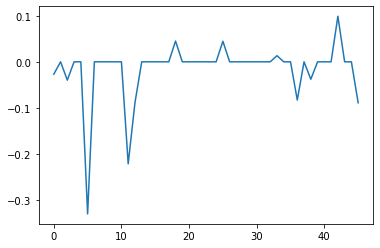

In [439]:
test_sentence()